# CNN With Dataset
Now time to talk about convolutional neural networks and in this notebook you will find out how by using the dataset one can do:
* Data augmentation
* Early stopping
* Decaying learning rate

In this example the [batch class](https://github.com/analysiscenter/az_training/blob/master/anton_broilovskiy/research/augmentation/my_batch.py) and the [model](https://github.com/analysiscenter/az_training/blob/master/anton_broilovskiy/research/augmentation/simple_conv_model.py) are used.

In [1]:
import sys

import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqn
%matplotlib inline

sys.path.append('../..')
sys.path.append('..')

import utils
from research.augmentation.my_batch import MnistBatch
from research.augmentation.simple_conv_model import ConvModel

from dataset import B,V,F
from dataset.dataset.opensets import MNIST

Instead of generating data, you can implement a basic batch class with preloaded [MNIST](https://analysiscenter.github.io/dataset/api/dataset.opensets.html#mnist) dataset.

In [2]:
mnist = MNIST(batch_class=MnistBatch)

Extracting Extracting/tmp/train-images-idx3-ubyte.gz
 Extracting /tmp/train-labels-idx1-ubyte.gz/tmp/t10k-labels-idx1-ubyte.gz
Extracting
 /tmp/t10k-images-idx3-ubyte.gz


As we already learned from the [first task](https://github.com/analysiscenter/az_training/blob/master/anton_broilovskiy/tutorials/I.Dataset/I.Dataset.ipynb),  in the very beginning the config and pipeline need to be created to train and test our model.

Let's create a config for a model. If you open the file with the [model](https://github.com/analysiscenter/az_training/blob/master/anton_broilovskiy/tutorials/II.CNN/simple_conv_model.py) you can see [__default_config__](https://analysiscenter.github.io/dataset/api/dataset.models.tf.base.html#dataset.models.tf.base.TFModel.default_config). It is a function, that allows you adding the default configuration to the model.

But if you want to override default config you can add parameters in model config. For example:

ConvModel has dict __config__ with key __'body'__. You can override it by adding in __model_config__ key __'body'__ with dict of params to body (as in [model](https://github.com/analysiscenter/az_training/blob/master/anton_broilovskiy/tutorials/II.CNN/simple_conv_model.py) file). 

Or add useful params by typing in a __model_config__ key like __'body/layout'__ and params to this key. Similar way use it in the key __'input_block/inputs'__ or __'head/units'__.

Models are split on three parts:
* __input_block__ - block containing the input layers.
* __body__ - the main part of the model
* __head__ - outputs layers, like GAP or dense layers.

In [3]:
model_config = {'inputs': dict(images={'shape': (28, 28, 1)},
                               labels={'classes': (10), 
                                       'transform': 'ohe', 
                                       'name': 'targets'}),
                'loss': 'softmax_cross_entropy',
                'decay': ('exp', {'learning_rate': 0.001,
                                  'decay_steps': 150,
                                  'decay_rate': 0.96}),
                'optimizer': 'RMSProp',
                'input_block/inputs': 'images',
                'head/units': 10,
                'output': dict(ops=['labels', 'proba', 'accuracy'])}

And don't forget about feed dict

In [4]:
data_dict = {'images': B('images'),
             'labels': B('labels')}

When config is complete, next step would be a pipeline. It is worth paying attention to the fact that __random_rotate__ and __random_scale__ are elements of the __ImagesBatch__ class(parent our class). You can see all writing augmentations in [examples](https://github.com/analysiscenter/dataset/blob/master/examples/simple_but_ugly/image_basic.py) for the Dataset.

In contrast to them __shift_flattned_pic__ is function from [my_batch](https://github.com/analysiscenter/az_training/blob/master/anton_broilovskiy/tutorials/II.CNN/my_batch.py). It is interesting because runs in parallel. About parallel method read [docs](https://analysiscenter.github.io/dataset/intro/parallel.html).

In [5]:
train_pipeline = (mnist.train.p
                 .shift_flattened_pic()
                 .random_rotate(p=.8, angle=(-45, 45), preserve_shape=True)
                 .random_scale(p=.8, factor=(.7, 1.3)) 
                 .init_variable('train_accuracy', init_on_each_run=list)
                 .init_model('dynamic',
                             ConvModel,
                             'conv',
                              config=model_config)
                 .train_model('conv',
                              fetches='accuracy',
                              feed_dict=data_dict,
                              save_to=V('train_accuracy'), mode='a'))

And test on same augmented data

In [6]:
test_pipeline = (mnist.test.p
                 .import_model('conv', train_pipeline)
                 .shift_flattened_pic()
                 .random_rotate(p=.8, angle=(-45, 45), preserve_shape=True)
                 .random_scale(p=.8, factor=(.7, 1.3))
                 .init_variable('test_accuracy', init_on_each_run=list)
                 .predict_model('conv', 
                             fetches='ConvModel/accuracy',
                             feed_dict=data_dict,
                             save_to=V('test_accuracy'), mode='a'))

We introduce early stopping to terminate the model when average accuracy in 'window' epochs will be more than 0.95 percent

In [7]:
MAX_ITER = 700
window = 50
average = [0]
batch_size = 100

for curr_iter in tqn(range(1, MAX_ITER + 1)):

    train_pipeline.next_batch(batch_size, n_epochs=None)
    test_pipeline.next_batch(batch_size, n_epochs=None)

    if curr_iter % window == 0:
        average.append(np.mean(test_pipeline.get_variable('test_accuracy')[curr_iter - window:]))

    #Early stopping   
    if average[-1] > 0.95:
        print('Early stop on {} iter. Acc: {}'.format(curr_iter, stats[-1]))
        break

Widget Javascript not detected.  It may not be installed or enabled properly.


Now we predict image class on test data and draw accuracy graph

../../utils.py:37: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  firt_ewma = ewma(np.array(first), span=window, adjust=False)
../../utils.py:38: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  second_ewma = ewma(np.array(second), span=window, adjust=False) if second else None


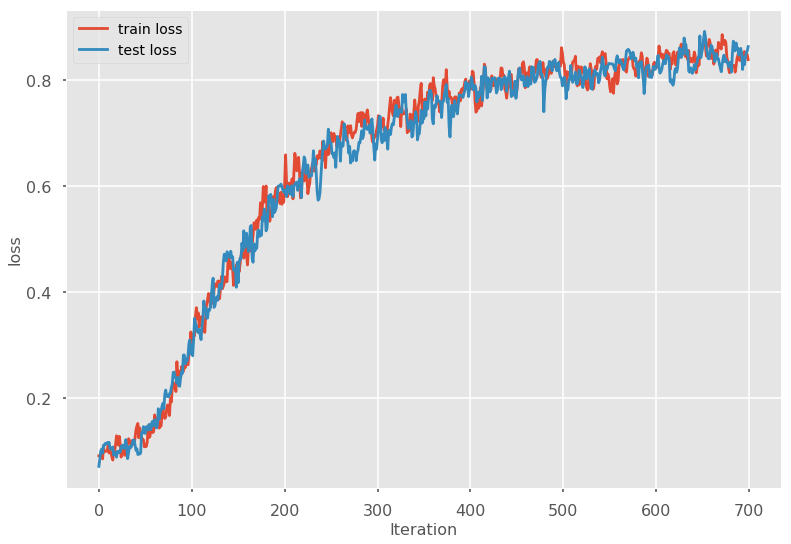

In [8]:
train_accuracy = train_pipeline.get_variable('train_accuracy')
test_accuracy = test_pipeline.get_variable('test_accuracy')
utils.draw(train_accuracy,'train', test_accuracy, 'test', 'loss')

Accuracy graph is probably good, but what about real predictions?

In [9]:
validation_pipeline = (mnist.test.p
                       .import_model('conv', train_pipeline)
                       .shift_flattened_pic()
                       .random_rotate(p=.8, angle=(-45, 45), preserve_shape=True)
                       .random_scale(p=.8, factor=(.7, 1.3))
                       .init_variable('answers', init_on_each_run=list)
                       .init_variable('img', init_on_each_run=list)
                       .init_variable('predict', init_on_each_run=list)
                       .init_variable('prob', init_on_each_run=list)
                       .predict_model('conv', 
                                      fetches=['labels', 
                                               'images', 
                                               'ConvModel/predicted_labels', 
                                               'ConvModel/predicted_proba'],
                                      feed_dict=data_dict,
                                      save_to=[V('answers'), V('img'), V('predict'), V('prob')], mode='a'))

It's always interesting to look at the images, so let's draw them.

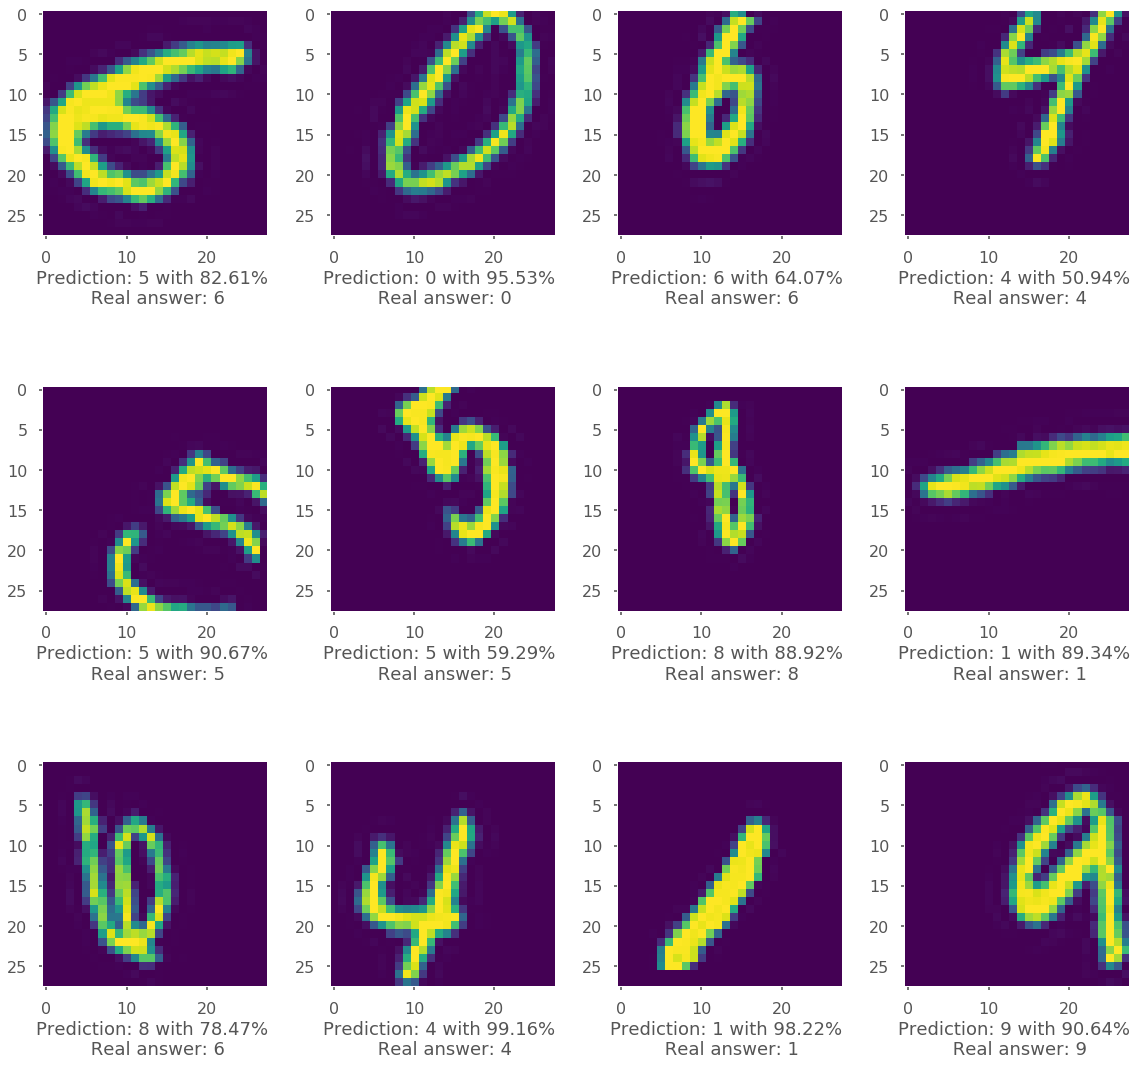

In [10]:
_, ax = plt.subplots(3, 4, figsize=(16, 16))
ax = ax.reshape(-1)


for num_batch in range(12):
    validation_pipeline.next_batch(1, n_epochs=None, shuffle=True)
    answer= validation_pipeline.get_variable('answers')
    img = validation_pipeline.get_variable('img')
    predict = validation_pipeline.get_variable('predict')
    prob = validation_pipeline.get_variable('prob')
    ax[num_batch].imshow(img[-1].reshape(-1, 28))
    ax[num_batch].set_xlabel('Prediction: {} with {:.2f}%\
                             \n Real answer: {}'.format(predict[-1][0],
                                                        prob[-1][0] \
                                                        [np.argmax(prob[-1])]*100, \
                                                        answer[-1][0]),\
                                                        fontsize=18)
    ax[num_batch].grid()
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

### Conclusions
* Today you got acquainted with convolutional neural network and how to create one within the dataset.
* Now you can use MNIST data without loading it in the pipeline.
* Discover the data augmentation.
* Get to know how to configure the model using model config.
* Find out that network can learn data augmentations (like scale and rotate). 

### And what next?
Because you know how to configure convolution model, you can create:
* model with MNIST 3-channels data, instead 1 in our example.
* config to our model, with own parameters of the network. Your goal is 0.93 on the test data!
Good luck!


In next notebook, we'll know what is best ResNet34 or ResNet50. Interested? [Click](https://github.com/analysiscenter/az_training/blob/master/anton_broilovskiy/tutorials/III.Models/III.Models.py).